<a href="https://colab.research.google.com/github/Ifeeding99/tensorflow-scripts/blob/main/mes_predictor_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving Prezzi orari mes.xlsx to Prezzi orari mes.xlsx


{'Prezzi orari mes.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00b\xee\x9dha\x01\x00\x00\x90\x04\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 32.2 MB/s 
     |████████████████████████████████| 7.6 MB 67.0 MB/s 
     |████████████████████████████████| 182 kB 75.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, MultiHeadAttention, GlobalAveragePooling1D, Conv1D, GlobalMaxPool1D, MaxPool1D

In [ ]:
df = pd.read_excel('Prezzi orari mes.xlsx', parse_dates = True, index_col = 'Date')
df.head()

,Hour,open,high,low,close,volume
Date,,,,,,
2022-09-07,220100,3993.75,4000.75,3993.75,3999.50,26
2022-09-07,230000,3997.75,3997.75,3997.75,3997.75,3
2022-09-08,0,3993.75,3994.00,3993.25,3993.75,28
2022-09-08,10000,3999.00,3999.00,3999.00,3999.00,3
2022-09-08,20000,3998.50,3998.75,3998.50,3998.75,12


In [ ]:
train_size = 1300
val_size = round((df.shape[0]-train_size)/2) + train_size
seq_len = 48

In [ ]:
X = df[['Hour', 'open']]
X = np.array(X, dtype = np.float32)
y = np.expand_dims(np.array(df.close, dtype = np.float32), axis = 1)
X_scaler = MinMaxScaler()
X_train = X[:train_size]
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
#X_train = np.expand_dims(X_train, axis = 2)
X_val = X[train_size:val_size]
X_val = X_scaler.transform(X_val)
#X_val = np.expand_dims(X_val, axis = 2)
X_test = X[val_size:]
X_test = X_scaler.transform(X_test)
#X_test = np.expand_dims(X_test, axis = 2)
y_train = y[seq_len:train_size]
Y_scaler = MinMaxScaler()
Y_scaler.fit(y_train)
y_train = Y_scaler.transform(y_train)
y_val = y[train_size+seq_len:val_size]
y_val = Y_scaler.transform(y_val)
y_test = y[val_size+seq_len:]
y_test = Y_scaler.transform(y_test)

In [ ]:
arr_train_X = np.zeros((len(X_train)-seq_len,seq_len,2),dtype=np.float32)
for i in range (len(X_train)-seq_len):
  arr_train_X[i] = X_train[i:i+seq_len]

arr_val_X = np.zeros((len(X_val)-seq_len,seq_len,2),dtype=np.float32)
for i in range (len(X_val)-seq_len):
  arr_val_X[i] = X_val[i:i+seq_len]

arr_test_X = np.zeros((len(X_test)-seq_len,seq_len,2),dtype=np.float32)
for i in range (len(X_test)-seq_len):
  arr_test_X[i] = X_test[i:i+seq_len]

In [ ]:
# model
input_ = Input(shape=(seq_len,2))
'''
x = Bidirectional(LSTM(64, return_sequences=True))(input_)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(256, return_sequences=False))(x)
x = Dense(256, activation = tf.nn.relu)(x)
x = Dense(256, activation = tf.nn.relu)(x)
x = Dense(1)(x)
'''

x = MultiHeadAttention()

model = Model(inputs = input_, outputs = x)
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = ['mae', 'mse'])

training = model.fit(arr_train_X, y_train,
                     validation_data = [arr_val_X, y_val],
                     epochs = 200)

KeyboardInterrupt: ignored

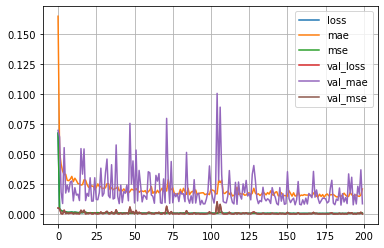

In [ ]:
history = pd.DataFrame(training.history)
history.plot()
plt.grid()

In [ ]:
model.evaluate(arr_test_X, y_test)

1/1 [==============================] - 0s 36ms/step - loss: 4.3916e-04 - mae: 0.0145 - mse: 4.3916e-04


[0.0004391636757645756, 0.014483338221907616, 0.0004391636757645756]

In [ ]:
model.save('modello_mes_v1')

In [ ]:
n_previsioni = 100
X_da_prevedere = np.array(df[['Hour','open']], dtype = np.float32)
X_da_prevedere = X_da_prevedere[-(n_previsioni+seq_len):]
y_reale = np.array(df['close'], dtype = np.float32)
y_reale = y_reale[-n_previsioni:]
X_scaled = X_scaler.transform(X_da_prevedere)

arr_da_prevedere = np.zeros((X_scaled.shape[0]-seq_len,seq_len,2), dtype = np.float32)
for i in range(X_scaled.shape[0]-seq_len):
  arr_da_prevedere[i] = X_scaled[i:i+seq_len]

previsioni = model.predict(arr_da_prevedere)
previsioni = Y_scaler.inverse_transform(previsioni)

4/4 [==============================] - 0s 15ms/step


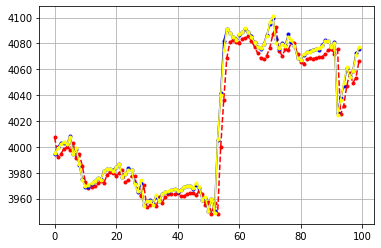

In [ ]:
time = [i for i in range (previsioni.shape[0])]
plt.plot(time, previsioni.ravel(), color = 'red', label = 'previsione', marker = '.', linestyle = '--')
plt.plot(time, y_reale, color = 'blue', label = 'reale', marker = '.')
plt.plot(time, df.open[-n_previsioni:], color = 'yellow', label = 'reale', marker = '.')
plt.grid()

In [ ]:
err_medio =  np.mean(abs(previsioni.ravel() - y_reale)) # se si aggiunge 5 alla previsione si arriva a mae 6.47
err_medio

8.267678

In [ ]:
profit = []
for i,el in enumerate(previsioni.ravel()):
  buy = True
  if previsioni.ravel()[i] > df.open[-n_previsioni + i]:
    buy = True
  else:
    buy = False

  if buy:
    profit.append((y_reale[i]-df.open[-n_previsioni + i]))
  else:
    profit.append(-(y_reale[i]-df.open[-n_previsioni + i]))


In [ ]:
profit_stupid = []
for i in range (n_previsioni):
  buy = True
  if df.open[-n_previsioni + i - 1] > df.open[-n_previsioni + i]:
    buy = True
  else:
    buy = False

  if buy:
    profit_stupid.append((y_reale[i]-df.open[-n_previsioni + i]))
  else:
    profit_stupid.append(-(y_reale[i]-df.open[-n_previsioni + i]))

In [ ]:
np.mean(profit)

0.06

In [ ]:
min(profit)

-7.25

In [ ]:
s = sum(profit) +7.25

0.13383838383838384

In [ ]:
max(profit)

3.25

In [ ]:
np.std(profit)

1.1175419455215094

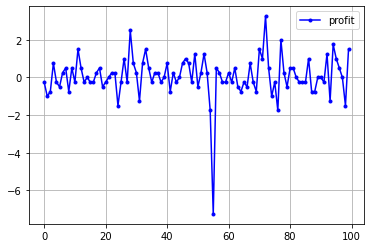

In [ ]:
plt.plot(time, profit, marker = '.', color = 'blue', label = 'profit')
plt.legend()
plt.grid()

In [ ]:
np.mean(profit_stupid)

0.04

In [ ]:
np.mean(abs(y_reale - df.open[-n_previsioni:]))

0.705

In [ ]:
profit_100 = profit[:-98]
guadagno = 0
for i in profit_100:
  guadagno += 10*i

guadagno

-12.5

In [ ]:
a = 0
giorni = 1
for i in range(giorni):
  for j in range (6):
    a *= 5
a

201.21964718355505

In [ ]:
import torch

In [ ]:
from transformers.models.time_series_transformer.modeling_time_series_transformer import TimeSeriesTransformerConfig
from transformers import TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(input_size = seq_len, prediction_length = 1)
transformer = TimeSeriesTransformerForPrediction(config)

In [ ]:
prova = df[:48]
prova.head()

,Hour,open,high,low,close,volume
Date,,,,,,
2022-09-07,220100,3993.75,4000.75,3993.75,3999.50,26
2022-09-07,230000,3997.75,3997.75,3997.75,3997.75,3
2022-09-08,0,3993.75,3994.00,3993.25,3993.75,28
2022-09-08,10000,3999.00,3999.00,3999.00,3999.00,3
2022-09-08,20000,3998.50,3998.75,3998.50,3998.75,12


In [ ]:
transformer(prova, past_time_features = prova['Date'], past_observed_mask = None, static_categorical_features = None, static_real_features = None)

TypeError: ignored

In [ ]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerModel

file = hf_hub_download(
    repo_id="kashif/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = TimeSeriesTransformerModel.from_pretrained("huggingface/time-series-transformer-tourism-monthly")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state

Downloading:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134k [00:00<?, ?B/s]

Some weights of the model checkpoint at huggingface/time-series-transformer-tourism-monthly were not used when initializing TimeSeriesTransformerModel: ['parameter_projection.proj.0.weight', 'parameter_projection.proj.2.bias', 'parameter_projection.proj.1.weight', 'parameter_projection.proj.1.bias', 'parameter_projection.proj.0.bias', 'parameter_projection.proj.2.weight']
- This IS expected if you are initializing TimeSeriesTransformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimeSeriesTransformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state

tensor([[[-0.3125, -1.2884, -1.1118,  ...,  1.0451,  0.4203,  3.0375],
         [-0.5801, -1.4907, -0.7782,  ...,  0.9608,  0.2682,  3.1201],
         [ 0.0849, -1.6557, -0.9755,  ...,  0.9067,  0.3701,  2.9377],
         ...,
         [-0.3410, -1.1548, -0.4904,  ...,  0.8370, -0.0492,  2.8411],
         [ 0.3200, -1.2751, -0.5913,  ...,  0.7770, -0.0708,  2.7629],
         [ 0.4449, -0.9840, -0.8680,  ...,  0.8528,  0.2259,  2.8575]],

        [[-0.4941, -1.6858, -1.1654,  ...,  1.0684,  0.3358,  3.3468],
         [-0.3336, -1.6143, -0.9035,  ...,  0.9299,  0.2294,  3.1584],
         [ 0.0308, -1.3468, -0.7522,  ...,  0.7283,  0.1293,  2.7877],
         ...,
         [-0.5414, -1.3957, -0.5848,  ...,  1.0298,  0.0777,  3.1478],
         [-0.6140, -1.5577, -0.8326,  ...,  0.9553,  0.0702,  3.1255],
         [ 0.0263, -1.6926, -1.0201,  ...,  1.0089,  0.1967,  3.3302]],

        [[ 0.2211,  1.2782, -0.0139,  ...,  0.8711, -0.3198,  2.8554],
         [ 1.0012,  1.6808,  0.0255,  ...,  0